In [20]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [22]:
import pandas as pd

dataset = pd.read_csv('../FASHIONMNIST/fashion-mnist_train.csv')


In [23]:
labels = dataset['label']
data = dataset.drop(columns=['label'])

In [24]:
data = np.array(data)
labels = np.array(labels)

In [25]:
data.shape,labels.shape

((60000, 784), (60000,))

In [26]:
X = torch.tensor(data, dtype=torch.float).reshape(-1, 1, 28, 28)
y = torch.tensor(labels, dtype=torch.long)

In [27]:
train_x, dev_x, train_y, dev_y = train_test_split(X, y, test_size=0.1)
train_dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(dev_x, dev_y)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [37]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 50, 3, 1, 1) # 14x14
        self.conv2 = nn.Conv2d(50, 100, 3, 1, 1) # 7x7x60
        self.conv3 = nn.Conv2d(100, 150, 3, 1, 1) # 3x3x100
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.batchnorm = nn.BatchNorm2d(50)
        self.batchnorm2 = nn.BatchNorm2d(100)
        self.batchnorm3 = nn.BatchNorm2d(150)

        self.dropout = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.15)
        self.linear1 = nn.Linear(3*3*150, 200)
        self.linear2 = nn.Linear(200, 10)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.pool(self.dropout2(self.relu(self.batchnorm(self.conv1(x)))))
        x = self.pool(self.dropout2(self.relu(self.batchnorm2(self.conv2(x)))))
        x = self.flatten(self.pool(self.dropout2(self.relu(self.batchnorm3(self.conv3(x))))))
        x = self.dropout(self.relu(self.linear1(x)))
        x = self.relu(self.linear2(x))
        return x

model = Net()

In [38]:
X, y = next(iter(train_loader))

# print(model(X)[0])
y.shape

torch.Size([64])

In [39]:
def train_the_model():
    loss_fn = nn.CrossEntropyLoss()
    model = Net()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    model.train()
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []

    for epoch in range(30):
        batch_losses = []
        batch_acc = []
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            yHat = model(X)
            loss = loss_fn(yHat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            accuracy = (torch.argmax(yHat, dim=1) == y).float().sum()
            batch_acc.append(accuracy.cpu() / y.shape[0])
            batch_losses.append(loss.item())
        train_acc.append(100*np.mean(batch_acc))
        train_loss.append(np.mean(batch_losses))

        with torch.no_grad():
            model.eval()
            X, y = next(iter(test_loader))
            X, y = X.to(device), y.to(device)
            yHat = model(X)
            loss = loss_fn(yHat, y)
            accuracy = (torch.argmax(yHat, dim=1) == y).float().sum()
            test_acc.append(100*accuracy.cpu() / y.shape[0])
            test_loss.append(loss.item())

    return model, train_acc, test_acc, train_loss, test_loss

In [40]:
model, train_acc, test_acc, train_loss, test_loss = train_the_model()

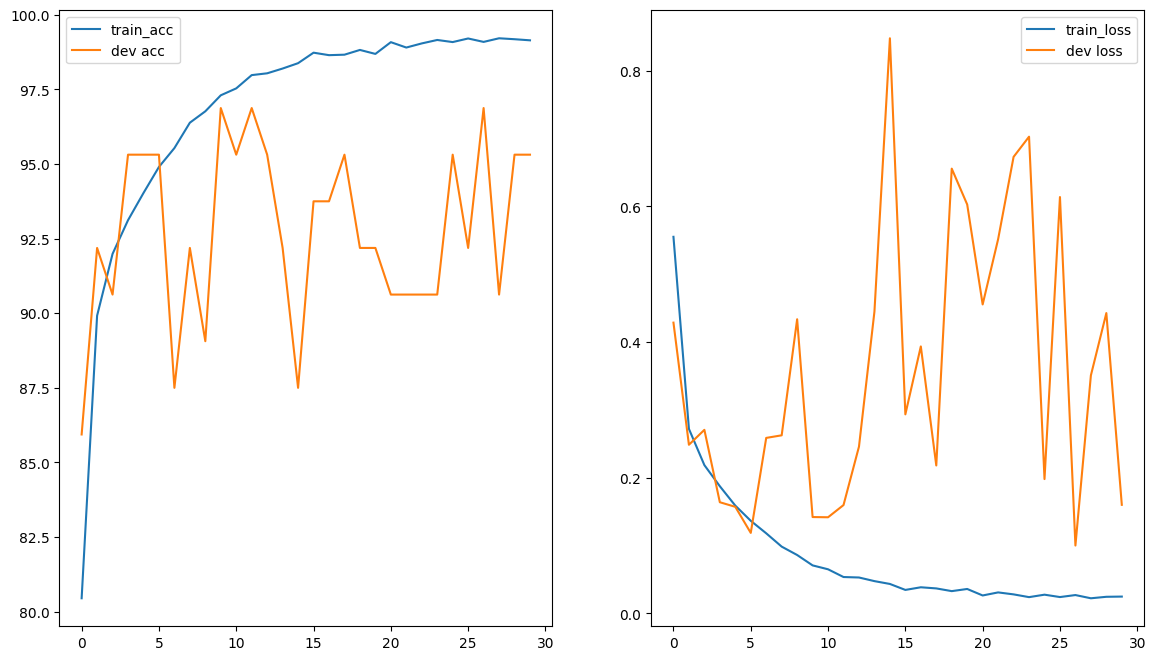

In [41]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 8))
ax[0].plot(train_acc, label="train_acc")
ax[0].plot(test_acc, label="dev acc")
ax[1].plot(train_loss, label="train_loss")
ax[1].plot(test_loss, label="dev loss")
ax[0].legend()
ax[1].legend()

In [42]:
labels_mapping = [ "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck" ]

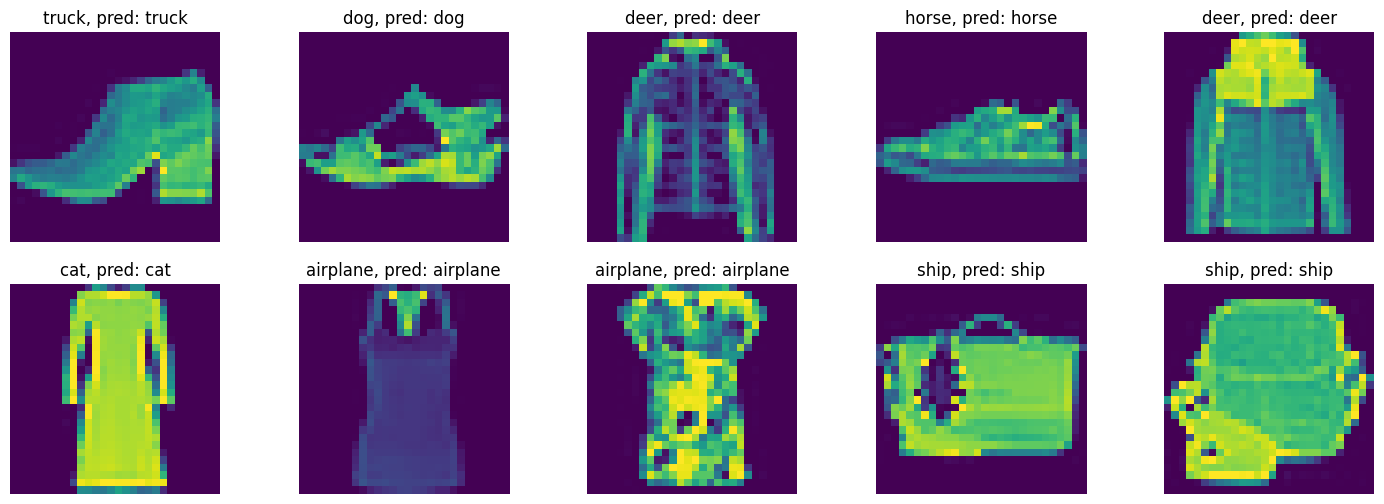

In [49]:
Xs = np.vstack(data)
ys = np.array(labels)
Xs = Xs[:1000]
ys = ys[:1000]
X_images = Xs.reshape(-1, 28, 28)
# X_images = np.transpose(X_images, ())

num_images = 10
random_indices = np.random.choice(Xs.shape[0], num_images, replace=False)

X = torch.tensor(Xs[:1000], dtype=torch.float, device=device).reshape(-1, 1, 28, 28)
y = torch.tensor(ys[:1000], dtype=torch.long, device=device).reshape(-1)

yHat = model(X[random_indices])
accuracy = torch.argmax(yHat, dim=1)

fig, axes = plt.subplots(2, 5, figsize=(18, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_images[random_indices[i]].astype(np.uint8))
    ax.axis("off")
    ax.set_title(f"{labels_mapping[ys[random_indices[i]]]}, pred: {labels_mapping[accuracy[i].item()]}")

plt.show()
